# Digital Earth Australia Intertidal workflow

## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
cd ..

/home/jovyan/dea_intertidal/dea-intertidal


Install additional packages directly from the requirements file

In [ ]:
pip install -r requirements.in --quiet

### Load packages

In [ ]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
from ipyleaflet import basemaps, basemap_to_tiles

import datacube
import odc.geo.xr
from odc.geo.geom import Geometry
from odc.ui import select_on_a_map
import cmocean

from intertidal.utils import (
    round_date_strings,
    intertidal_hillshade,
)
from intertidal.tide_modelling import pixel_tides_ensemble
from intertidal.io import (
    load_data,
    load_topobathy_mask,
    load_aclum_mask,
    prepare_for_export,
)
from intertidal.elevation import elevation
from intertidal.extents import extents
from intertidal.exposure import exposure
from intertidal.tidal_bias_offset import bias_offset

from dea_tools.dask import create_local_dask_cluster

## Setup


### Set analysis parameters

In [ ]:
# Intertidal Elevation variables
start_date = "2020"  # Start date for analysis
end_date = "2022"  # End date for analysis
resolution = 30  # Spatial resolution used for output files
crs = "EPSG:3577"  # Coordinate Reference System (CRS) to use for output files
ndwi_thresh = 0.1  # Threshold used to identify dry/wet transition
include_s2 = True  # Include Sentinel-2 data in the analysis?
include_ls = True  # Include Landsat data in the analysis?
filter_gqa = True  # Filter to remove poorly georeferenced scenes?
tide_model = "ensemble"  # Tide model to use in analysis
tide_model_dir = "/gdata1/data/tide_models_clipped"

# Exposure variables
modelled_freq = "3h"  # Frequency to run tidal model e.g '30min' or '1h'
filters=None # Exposure filters eg None, ['Dry', 'Neap_low']
filters_combined = None ## Must be a list of tuples containing one temporal and spatial filter each, eg None or [('Einter','Lowtide')]

##### Option 1: load study area from 32 km tile GridSpec

In [ ]:
# # Set study area (e.g. tile ID in form "x094y145")
# study_area = "x094y145"
# geom = None  # Use GridSpec to load study area, not a custom geom

##### Option 2: load study area from vector file

In [ ]:
# # Set study area to load from file
# study_area = "pointstuart"

# # Read file, select study area and convert to geom
# studyarea_gdf = gpd.read_file(
#     "data/raw/intertidal_development_polygons.geojson"
# ).set_index("id")
# geom = Geometry(studyarea_gdf.loc[study_area].geometry, crs=studyarea_gdf.crs)
# geom

##### Option 3: load study area using interactive map

In [ ]:
# Set study area name for outputs
study_area = "testing"

# Plot interactive map to select area
basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
geom = select_on_a_map(height="600px", layers=(basemap,), center=(-26, 135), zoom=4)
geom

## Intertidal workflow

### Load data

In [8]:
%%time

# Connect to datacube
dc = datacube.Datacube(app="Intertidal_elevation")

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

satellite_ds,_,_ = load_data(
    dc=dc,
    study_area=study_area,
    geom=geom,
    time_range=(start_date, end_date),
    resolution=resolution,
    crs=crs,
    include_s2=True,
    include_ls=True,
    filter_gqa=filter_gqa,
    max_cloudcover=90,
    skip_broken_datasets=True,
)

print(satellite_ds)

# Load data
satellite_ds.load()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 7,Total memory: 59.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44371,Workers: 1
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,Total threads: 7
Started: Just now,Total memory: 59.21 GiB
Comm: tcp://127.0.0.1:45421,Total threads: 7
Dashboard: /user/claire.phillips@ga.gov.au/proxy/42527/status,Memory: 59.21 GiB
Nanny: tcp://127.0.0.1:38685,


<xarray.Dataset>
Dimensions:      (time: 412, y: 231, x: 203)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-03T01:01:55.695772 ... 2022-12...
  * y            (y) float64 -1.886e+06 -1.886e+06 ... -1.892e+06 -1.893e+06
  * x            (x) float64 8.043e+05 8.043e+05 ... 8.103e+05 8.103e+05
    spatial_ref  int32 3577
Data variables:
    ndwi         (time, y, x) float32 dask.array<chunksize=(1, 231, 203), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref


/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


CPU times: user 11 s, sys: 1.32 s, total: 12.3 s
Wall time: 1min 22s


<xarray.Dataset>
Dimensions:      (time: 412, y: 231, x: 203)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-03T01:01:55.695772 ... 2022-12...
  * y            (y) float64 -1.886e+06 -1.886e+06 ... -1.892e+06 -1.893e+06
  * x            (x) float64 8.043e+05 8.043e+05 ... 8.103e+05 8.103e+05
    spatial_ref  int32 3577
Data variables:
    ndwi         (time, y, x) float32 0.3569 0.3635 0.3735 ... nan nan nan
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

### Load optional topobathy mask
Loads a topo-bathymetric DEM for the extents of the loaded satellite data.
This is used as a coarse mask to constrain the analysis to the coastal zone, improving run time and reducing clear false positives over deep water or elevated land.

In [9]:
# Load data from GA's AusBathyTopo 250m 2023 Grid
topobathy_mask = load_topobathy_mask(dc, geobox=satellite_ds.odc.geobox.compat)

### Intertidal elevation
To run without the topobathy DEM mask, comment out `valid_mask=...`.

In [10]:
# Model elevation for each pixel
ds, tide_m = elevation(
    satellite_ds,
    valid_mask=topobathy_mask,
    tide_model=tide_model,
    tide_model_dir=tide_model_dir,
)

2024-05-09 04:35:57 INFO Processing: Modelling tide heights for each pixel


Running ensemble tide modelling
Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014, FES2012, TPXO8-atlas-v1, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10 in parallel


100%|██████████| 35/35 [00:35<00:00,  1.01s/it]


Returning low resolution tide array
Generating ensemble tide model from point inputs
Interpolating model weights using 'idw' interpolation
                 weights
tide_model              
FES2014         0.443835
GOT4.10         0.441578
EOT20           0.438455
FES2012         0.435345
TPXO9-atlas-v5  0.428795
TPXO8-atlas-v1  0.402622
HAMTIDE11       0.203921
Reducing multiple models into single ensemble model using 'mean'
Reprojecting ensemble tides into original array


2024-05-09 04:36:38 INFO Processing: Masking nodata and adding tide heights to satellite data array
2024-05-09 04:36:38 INFO Processing: Flattening satellite data array and filtering to intertidal candidate pixels
2024-05-09 04:36:38 INFO Processing: Applying valid data mask to constrain study area
2024-05-09 04:36:39 INFO Processing: Running per-pixel rolling median


Reducing analysed pixels from 46893 to 14622 (31.18%)


  0%|          | 0/105 [00:00<?, ?it/s]

2024-05-09 04:36:56 INFO Processing: Modelling intertidal elevation
2024-05-09 04:36:56 INFO Processing: Modelling intertidal uncertainty


Applying tidal interval interpolation to 200 intervals
Applying rolling mean smoothing with radius 20


2024-05-09 04:36:57 INFO Processing: Unflattening data back to its original spatial dimensions
2024-05-09 04:36:57 INFO Processing: Cleaning inaccurate upper intertidal pixels
2024-05-09 04:36:57 INFO Processing: Successfully completed intertidal elevation modelling


### Intertidal extents


In [11]:
# Load and reclassify for intensive urban land use class only the ABARES ACLUM ds
reclassified_aclum = load_aclum_mask(dc, geobox=satellite_ds.odc.geobox.compat)

# Calculate intertidal extents
ds["extents"] = extents(
    dem=ds.elevation,
    freq=ds.qa_ndwi_freq,
    corr=ds.qa_ndwi_corr,
    reclassified_aclum=reclassified_aclum,
)

In [12]:
# ## Plot with labels
# labels=['0 Dry',
#        '1 Intermittent\n   wet\n   inland',
#        '2 Wet inland',
#        '3 Wet ocean',
#        '4 Intertidal lc',
#        '5 Intertidal hc',
#        ]

# fig,ax=plt.subplots(figsize=(12,8))
# cax=ax.imshow(ds['extents'], cmap='terrain_r')
# cbar=fig.colorbar(cax, ticks=[0,1,2,3,4,5])
# cbar.ax.set_yticklabels(labels)
# plt.show()

### Intertidal exposure
Calculate exposure using the script function.
To calculate exposure for the full time period, leave `filters` commented out or set as ['unfiltered'].
See the function documentation for the full range of available filters and filter_combinations.
The code accepts lists of multiple filters and filter_combination tuples.

In [40]:
%reload_ext autoreload
filters=['Summer', 'Feb', 'Night', 'Lowtide']

exposure_filters, tide_cq_dict = exposure(
    dem=ds.elevation,
    start_date=start_date,
    end_date=end_date,
    modelled_freq = modelled_freq,
    tide_model=tide_model,
    tide_model_dir=tide_model_dir,
    filters=filters,
    filters_combined=filters_combined,
)

for x in list(exposure_filters.keys()):
    ds['exposure_'+str(x)]=exposure_filters[str(x)]

Running ensemble tide modelling
Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014, FES2012, TPXO8-atlas-v1, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10 in parallel


100%|██████████| 35/35 [00:42<00:00,  1.21s/it]


Returning low resolution tide array
Generating ensemble tide model from point inputs
Interpolating model weights using 'idw' interpolation
                 weights
tide_model              
FES2014         0.443835
GOT4.10         0.441578
EOT20           0.438455
FES2012         0.435345
TPXO9-atlas-v5  0.428795
TPXO8-atlas-v1  0.402622
HAMTIDE11       0.203921
Reducing multiple models into single ensemble model using 'mean'
Returning low resolution ensemble tide array
-----
Calculating Summer timerange
-----
Calculating Feb timerange
-----
Calculating Night timerange
-----
Calculating Lowtide exposure
-----
Calculating Summer exposure
-----
Calculating Feb exposure


KeyError: "'time' is not a valid dimension or coordinate"

In [32]:
ds

<xarray.Dataset>
Dimensions:                  (y: 231, x: 203)
Coordinates:
  * y                        (y) float64 -1.886e+06 -1.886e+06 ... -1.893e+06
  * x                        (x) float64 8.043e+05 8.043e+05 ... 8.103e+05
    spatial_ref              int32 3577
    time                     datetime64[ns] 2021-12-21T14:26:59.325771
Data variables: (12/14)
    elevation                (y, x) float64 -1.517 -1.52 ... -0.6338 -0.6679
    elevation_uncertainty    (y, x) float64 0.4187 0.5615 ... 0.1808 0.2358
    qa_ndwi_corr             (y, x) float64 0.3296 0.3343 ... 0.7022 0.675
    qa_ndwi_freq             (y, x) float64 0.9689 0.9685 ... 0.783 0.8008
    extents                  (y, x) float64 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0
    exposure_unfiltered      (y, x) float64 3.0 3.0 3.0 2.0 ... 28.0 26.0 25.0
    ...                       ...
    exposure_Dry             (y, x) float64 3.0 3.0 3.0 2.0 ... 29.0 27.0 25.0
    exposure_Winter          (y, x) float64 3.0 3.0 3.0 3.0 ... 28.0 27.0 25.0
    exposure_Winter_Lowtide  (y, x) float64 20.0 20.0 19.0 ... 84.0 81.0 78.0
    exposure_Summer          (y, x) float64 3.0 3.0 3.0 2.0 ... 26.0 24.0 23.0
    exposure_Feb             (y, x) float64 2.0 2.0 2.0 2.0 ... 25.0 24.0 23.0
    exposure_Night           (y, x) float64 3.0 3.0 3.0 2.0 ... 28.0 26.0 25.0

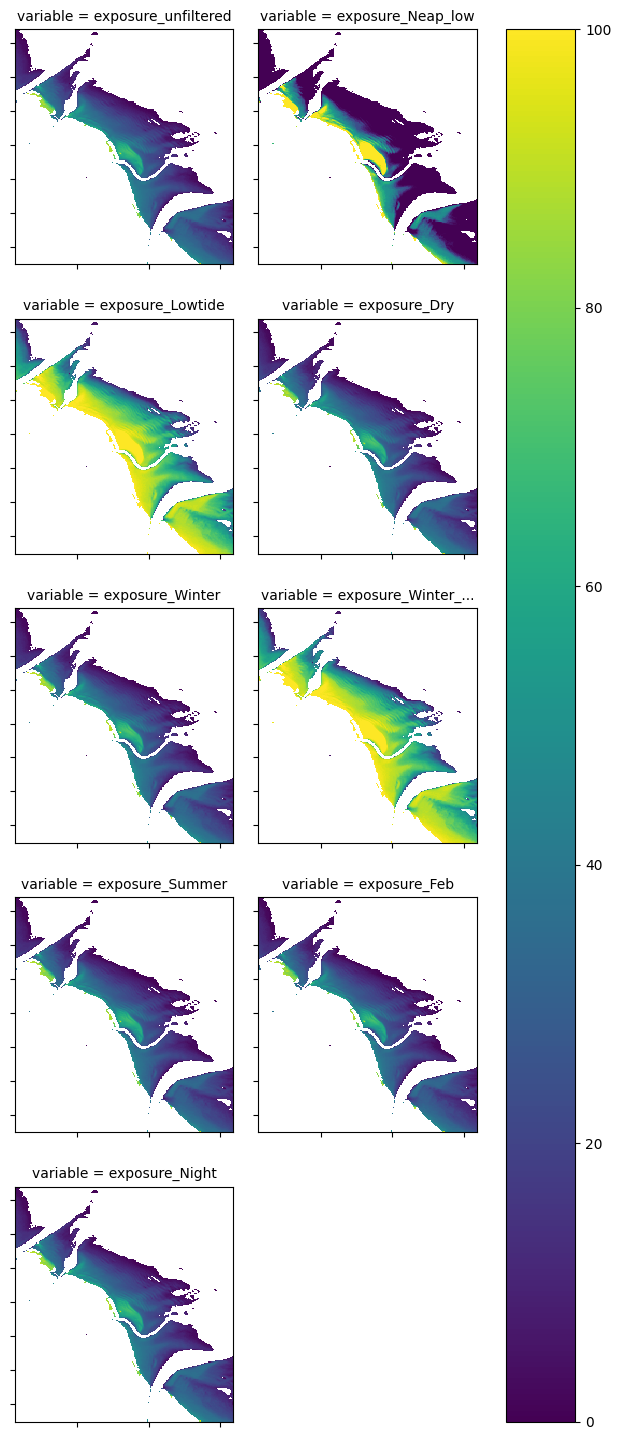

In [34]:
fig = ds[['exposure_unfiltered', 
          'exposure_Neap_low',
          'exposure_Lowtide',
          'exposure_Dry',
          'exposure_Winter',
          'exposure_Winter_Lowtide',
          'exposure_Summer',
          'exposure_Feb',
          'exposure_Night']].to_array().plot(col='variable', col_wrap=2)

for ax in fig.axs.flat:
    ax.label_outer()
    ax.set_xticklabels(labels="")
    ax.set_yticklabels(labels="")
    ax.set_xlabel("")
    ax.set_ylabel("")

### Spread and offset
Calculate the spread and high/low tide biases of input observed images as a percentage of the modelled tide heights.

Warning: this code will only work if the exposure function has been run and produced 'unfiltered' exposure results.


In [24]:
(
    ds["ta_lat"],
    ds["ta_hat"],
    ds["ta_lot"],
    ds["ta_hot"],
    ds["ta_spread"],
    ds["ta_offset_low"],
    ds["ta_offset_high"],
) = bias_offset(
    tide_m=tide_m, tide_cq=tide_cq_dict['unfiltered'], lot_hot=True, lat_hat=True
)

## Plot all layers

In [25]:
# Inspect contents of ds before plotting
ds

<xarray.Dataset>
Dimensions:                  (y: 279, x: 442)
Coordinates:
  * y                        (y) float64 -1.891e+06 -1.891e+06 ... -1.9e+06
  * x                        (x) float64 8.118e+05 8.119e+05 ... 8.251e+05
    spatial_ref              int32 3577
    time                     datetime64[ns] 2021-12-21T14:26:59.325771
Data variables: (12/18)
    elevation                (y, x) float64 nan nan nan ... -0.0008867 0.02731
    elevation_uncertainty    (y, x) float64 nan nan nan ... 0.2737 0.2651 0.27
    qa_ndwi_corr             (y, x) float64 nan nan nan ... 0.7475 0.7452 0.743
    qa_ndwi_freq             (y, x) float64 0.9954 1.0 1.0 ... 0.6119 0.6147
    extents                  (y, x) float64 3.0 3.0 3.0 3.0 ... 5.0 5.0 5.0 5.0
    exposure_unfiltered      (y, x) float64 nan nan nan nan ... 51.0 51.0 52.0
    ...                       ...
    ta_hat                   (y, x) float32 2.325 2.325 2.325 ... 2.348 2.348
    ta_lot                   (y, x) float32 -2.164 -2.164 ... -2.165 -2.165
    ta_hot                   (y, x) float32 2.069 2.069 2.069 ... 2.077 2.077
    ta_spread                (y, x) float32 92.89 92.89 92.89 ... 92.46 92.46
    ta_offset_low            (y, x) float32 1.491 1.491 1.491 ... 1.627 1.627
    ta_offset_high           (y, x) float32 5.618 5.618 5.618 ... 5.913 5.913

<Figure size 640x480 with 0 Axes>

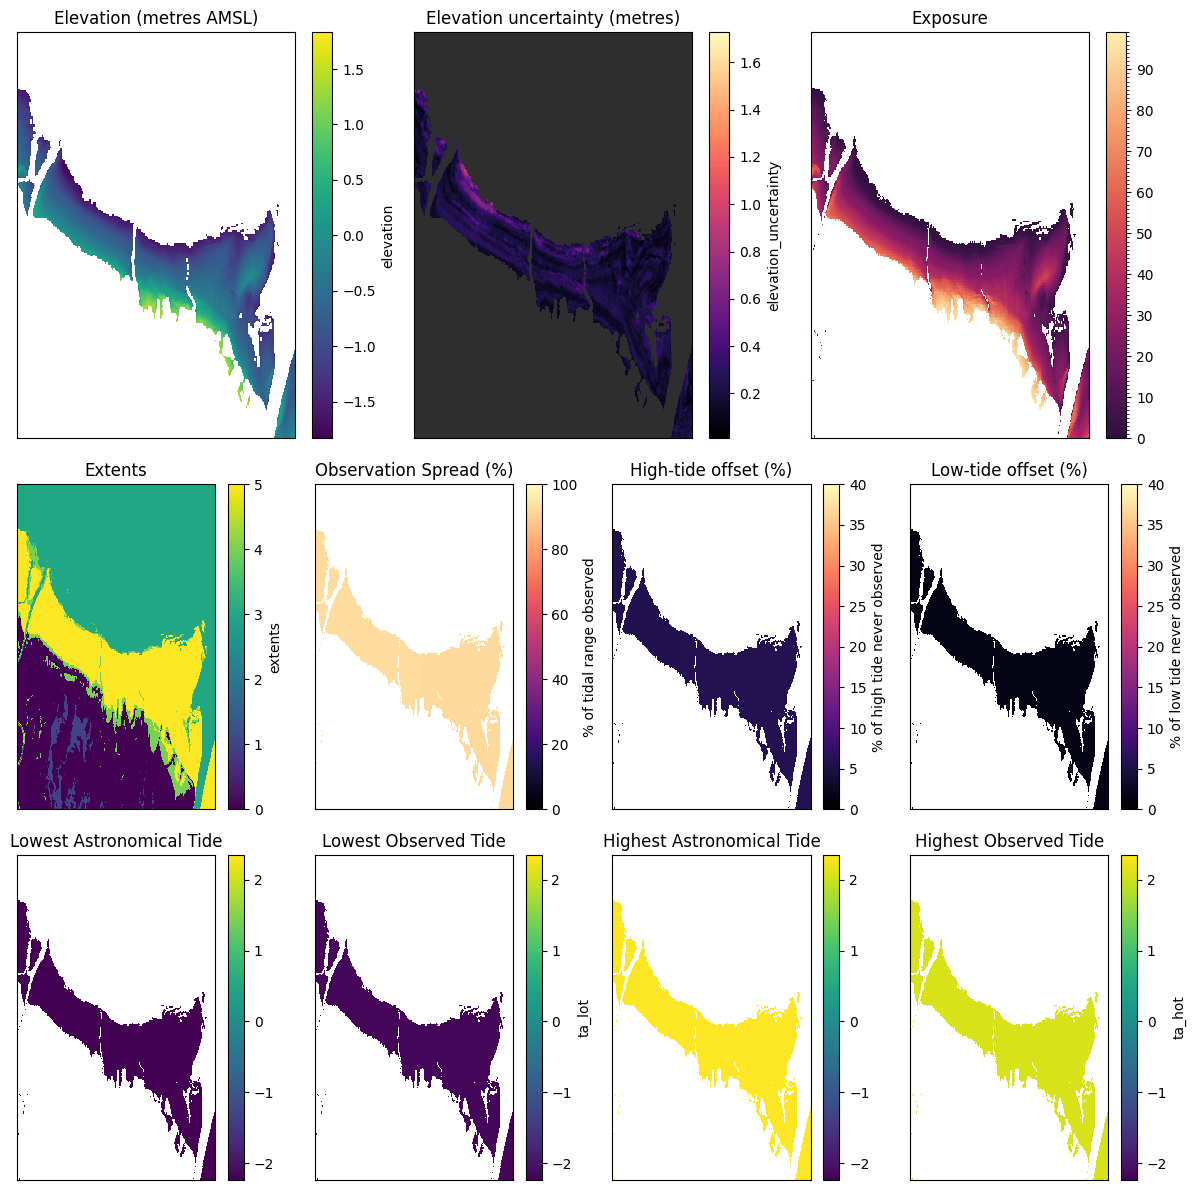

In [26]:
plt.clf()

fig = plt.figure(figsize=(12, 12), tight_layout=True)
ax_dict = fig.subplot_mosaic(
    """
    AAAABBBBCCCC
    DDDEEEFFFGGG
    HHHIIIJJJKKK
    """,
    height_ratios=[1, 0.8, 0.8],
)

# label_params = dict(add_labels=False, yticks=[], xticks=[])

# Plot Elevation with hillshade
ds["elevation"].plot.imshow(
    ax=ax_dict["A"],
    cmap="viridis",
    interpolation="bilinear",
)
# intertidal_hillshade(ds["elevation"], ds["qa_ndwi_freq"], vert_exag=300).plot.imshow(
#     ax=ax_dict["A"],
#     interpolation="bilinear",
# )
ax_dict["A"].set_title("Elevation (metres AMSL)")

# Plot uncertainty
ds["elevation_uncertainty"].plot.imshow(
    ax=ax_dict["B"],
    cmap="magma",
    interpolation="bilinear",
)
ax_dict["B"].set_title("Elevation uncertainty (metres)")
ax_dict["B"].set_facecolor("#2E2E2E")

# Plot Exposure
ds["exposure_unfiltered"].plot.imshow(
    ax=ax_dict["C"],
    cmap=cmocean.cm.matter_r,
    levels=np.arange(0, 100, 1),
    add_labels=False,
    yticks=[],
)
ax_dict["C"].set_title("Exposure")

# Plot Extents
ds["extents"].astype(np.int16).plot.imshow(ax=ax_dict["D"])
ax_dict["D"].set_title("Extents")

# Plot the observation spread
ds["ta_spread"].where(ds.elevation.notnull()).plot.imshow(
    ax=ax_dict["E"],
    vmin=0,
    vmax=100,
    cmap="magma",
    cbar_kwargs={"label": "% of tidal range observed"},
)
ax_dict["E"].set_title("Observation Spread (%)")

# Plot the high-tide offset
ds["ta_offset_high"].where(ds.elevation.notnull()).plot.imshow(
    ax=ax_dict["F"],
    vmin=0,
    vmax=40,
    cmap="magma",
    cbar_kwargs={"label": "% of high tide never observed"},
)
ax_dict["F"].set_title("High-tide offset (%)")

# Plot the low-tide offset
ds["ta_offset_low"].where(ds.elevation.notnull()).plot.imshow(
    ax=ax_dict["G"],
    vmin=0,
    vmax=40,
    cmap="magma",
    cbar_kwargs={"label": "% of low tide never observed"},
)
ax_dict["G"].set_title("Low-tide offset (%)")

# Plot the LAT
ds["ta_lat"].where(ds.elevation.notnull()).plot.imshow(
    ax=ax_dict["H"],
    vmin=ds["ta_lat"].min(),
    vmax=ds["ta_hat"].max(),
    add_labels=False,
)
ax_dict["H"].set_title("Lowest Astronomical Tide")

# Plot the LOT
ds["ta_lot"].where(ds.elevation.notnull()).plot.imshow(
    ax=ax_dict["I"], vmin=ds["ta_lat"].min(), vmax=ds["ta_hat"].max()
)
ax_dict["I"].set_title("Lowest Observed Tide")

# Plot the HAT
ds["ta_hat"].where(ds.elevation.notnull()).plot.imshow(
    ax=ax_dict["J"],
    vmin=ds["ta_lat"].min(),
    vmax=ds["ta_hat"].max(),
    add_labels=False,
    yticks=[],
)
ax_dict["J"].set_title("Highest Astronomical Tide")

# Plot the HOT
ds["ta_hot"].where(ds.elevation.notnull()).plot.imshow(
    ax=ax_dict["K"],
    vmin=ds["ta_lat"].min(),
    vmax=ds["ta_hat"].max(),
)
ax_dict["K"].set_title("Highest Observed Tide")

# # Plot the high and low tidelines with respective offset
# ax_dict["L"].set_title("Lowtide line and lowtide offset")
# # lowtideline.plot(
# #     column="offset_lowtide",
# #     legend=True,
# #     vmin=0,
# #     vmax=40,
# #     cmap="magma",
# #     ax=ax_dict["L"],
# #     zorder=2,
# # )
# # tidelines_gdf.loc[[0], "geometry"].plot(ax=ax_dict["L"], zorder=1)
# ax_dict["L"].set_xlim(left=ds.elevation.x.min(), right=ds.elevation.x.max())
# ax_dict["L"].set_ylim(bottom=ds.elevation.y.min(), top=ds.elevation.y.max())

# ax_dict["M"].set_title("Hightide line and hightide offset")
# # hightideline.plot(
# #     column="offset_hightide",
# #     legend=True,
# #     vmin=0,
# #     vmax=40,
# #     cmap="magma",
# #     ax=ax_dict["M"],
# #     zorder=2,
# # )
# # tidelines_gdf.loc[[1], "geometry"].plot(ax=ax_dict["M"], zorder=1)
# ax_dict["M"].set_yticks([])
# ax_dict["M"].set_xlim(left=ds.elevation.x.min(), right=ds.elevation.x.max())
# ax_dict["M"].set_ylim(bottom=ds.elevation.y.min(), top=ds.elevation.y.max())

# Remove axis labels
for label, ax in ax_dict.items():
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylabel("")
    ax.set_xlabel("")

## Export layers

In [27]:
# Create output folder if it doesn't exist
output_dir = f"data/interim/{study_area}/{start_date}-{end_date}"
os.makedirs(output_dir, exist_ok=True)

# Prepare data for export
ds["qa_ndwi_freq"] *= 100  # Convert frequency to %

# Prepare for export by correctly setting nodata and dtypes, then
# export to file
ds_prepared = prepare_for_export(ds, output_location=output_dir)

In [28]:
# Export figure
fig.savefig(f"data/interim/{study_area}/{start_date}-{end_date}/outputs.png")

### Close Dask client

In [29]:
client.close()